In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
import os
import glob
import random

from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras import Input
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
best_model = load_model('/content/gdrive/MyDrive/DATK/Check/GRU_model_17_7.h5')

In [7]:
def generate_csv(folder, label):
    folder_name = os.path.basename(folder)
    labels = list(label)
    gender_folder={'Nam','Nu'}
    genders = list(gender_folder)
    print(labels)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for gender in genders:
     for label in labels:
        print("Reading", os.path.join(folder, gender, label, "*"))
        for filepath in glob.glob(os.path.join(folder, gender, label, "*","*.wav")):
            df.loc[i] = [filepath,label]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)
# dir_folder = '/content/gdrive/MyDrive/DATK/Training/Number'
dir_folder = '/content/gdrive/MyDrive/DATK/Check/Test'
generate_csv(dir_folder, {'zero','one','two','three','four','five','six','seven','eight','nine'})

['nine', 'zero', 'three', 'five', 'seven', 'eight', 'six', 'one', 'four', 'two']
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nu/nine/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nu/zero/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nu/three/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nu/five/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nu/seven/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nu/eight/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nu/six/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nu/one/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nu/four/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nu/two/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nam/nine/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nam/zero/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nam/three/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nam/five/*
Reading /content/gdrive/MyDrive/DATK/Check/Test/Nam/seven/*
Reading /content/gdrive/MyDrive/DATK/Check

In [8]:
# metadata_filename = "Number.csv"
metadata_filename = "Test.csv"
# load CSV files as DataFrames
metadata = pd.read_csv(metadata_filename)
metadata.tail()

,Unnamed: 0,filepath,label
5140,5140,/content/gdrive/MyDrive/DATK/Check/Test/Nam/tw...,two
5141,5141,/content/gdrive/MyDrive/DATK/Check/Test/Nam/tw...,two
5142,5142,/content/gdrive/MyDrive/DATK/Check/Test/Nam/tw...,two
5143,5143,/content/gdrive/MyDrive/DATK/Check/Test/Nam/tw...,two
5144,5144,/content/gdrive/MyDrive/DATK/Check/Test/Nam/tw...,two


In [9]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name)

    # Tính toán số frame trong mỗi frame có độ dài 25ms với sampling rate là 16000
    frame_length = int(0.025 * sample_rate)
    # Tính toán số sample overlap trong frame overlap 10ms với sampling rate là 16000
    hop_length = int(0.01 * sample_rate)
    # Tính toán kích thước FFT (Fast Fourier Transform) trong hàm mfcc
    n_fft = 2 ** int(np.ceil(np.log2(frame_length)))

    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    mfccs = np.zeros((13,101))
    mfccs[:mfcc.shape[0], :mfcc.shape[1]]=mfcc
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    mfccs_features = np.transpose(mfccs_features)

    return mfccs_features

In [10]:
extracted_features1=[]
for index_num,row in metadata.iterrows():
    filename = str(row["filepath"])
    final_class_labels=row["label"]
    data=features_extractor(filename)
    extracted_features1.append([data,final_class_labels])

In [11]:
extracted_features_df=pd.DataFrame(extracted_features1,columns=['feature','class'])
outputfile = f"{'extracted_feature_file'}.csv"
extracted_features_df.to_csv(outputfile)
extracted_features_df.tail()

,feature,class
5140,"[[-670.71533203125, -9.740005493164062, -3.386...",two
5141,"[[-715.0545654296875, 0.3255135715007782, 0.19...",two
5142,"[[-707.3507690429688, 0.3257714509963989, 0.31...",two
5143,"[[-669.9050903320312, 0.0, 0.0, 0.0, 0.0, 0.0,...",two
5144,"[[-385.47357177734375, 69.66758728027344, -21....",two


In [12]:
x_data = np.stack(extracted_features_df['feature'])
y_data =np.array(extracted_features_df['class'].tolist())
x_data.shape

(5145, 101, 39)

In [13]:
pre_y_test = []
pre_test = best_model.predict(x_data, verbose=0)
for i in range(0,len(y_data)):
  s=0
  for j in pre_test[i]:
    if j > 5.0e-1:
      break
    s=s+1
  match s:
    case 0:
      pre_y_test.append(["eight",y_data[i]])
    case 1:
      pre_y_test.append(["five",y_data[i]])
    case 2:
      pre_y_test.append(["four",y_data[i]])
    case 3:
      pre_y_test.append(["nine",y_data[i]])
    case 4:
      pre_y_test.append(["one",y_data[i]])
    case 5:
      pre_y_test.append(["seven",y_data[i]])
    case 6:
      pre_y_test.append(["six",y_data[i]])
    case 7:
      pre_y_test.append(["three",y_data[i]])
    case 8:
      pre_y_test.append(["two",y_data[i]])
    case 9:
      pre_y_test.append(["zero",y_data[i]])
value_test=pd.DataFrame(pre_y_test,columns=['predict_label','reference_label'])
value_test

,predict_label,reference_label
0,nine,nine
1,nine,nine
2,nine,nine
3,nine,nine
4,nine,nine
...,...,...
5077,two,two
5078,two,two
5079,two,two
5080,two,two


In [14]:
testy = value_test['reference_label'].tolist()
ypredict = value_test['predict_label'].tolist()
testyarr = np.array(value_test['reference_label'].tolist())
preyarr = np.array(value_test['predict_label'].tolist())
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, ypredict)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testyarr, preyarr,average = 'micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, ypredict,average = 'micro' )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, ypredict,average = 'micro')
print('F1 score: %f' % f1)

Accuracy: 0.954152
Precision: 0.954152
Recall: 0.954152
F1 score: 0.954152


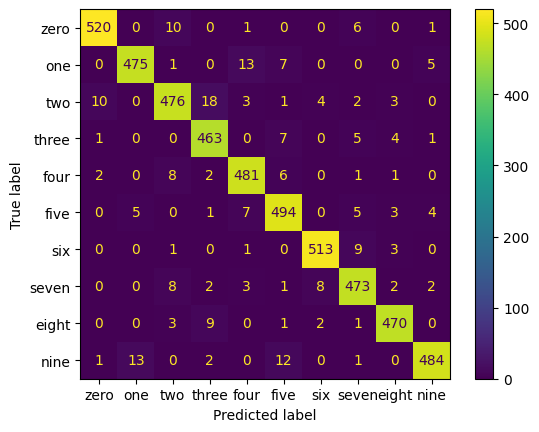

In [15]:
conf_matrix = confusion_matrix(testy,ypredict,labels = ["zero","one","two","three","four","five","six","seven","eight","nine"])
disp = ConfusionMatrixDisplay( confusion_matrix=conf_matrix, display_labels=["zero","one","two","three","four","five","six","seven","eight","nine"])
disp.plot()
plt.show()

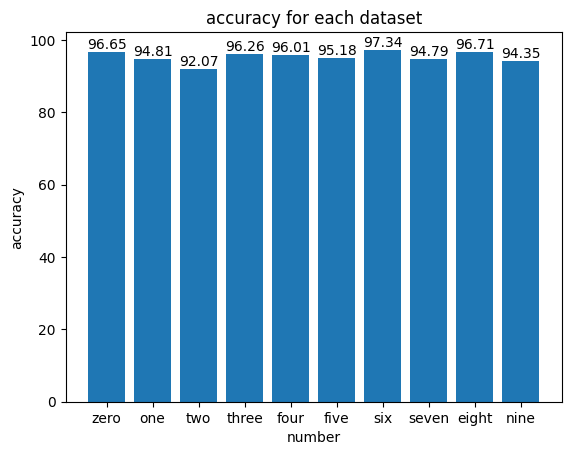

In [16]:
acc_per = []
for i in range(0,10):
  sum_label = 0
  for j in range(0,10):
    sum_label = sum_label + conf_matrix[i][j]
  accu = float(conf_matrix[i][i]/sum_label)
  acc_per.append(round(accu,4)*100)
labels =  ["zero","one","two","three","four","five","six","seven","eight","nine"]
plt.bar(labels,acc_per)
for i in range(len(labels)):
    plt.text(labels[i], acc_per[i], f"{acc_per[i]:.2f}", ha='center', va='bottom')
plt.xlabel("number")
plt.ylabel("accuracy")
plt.title("accuracy for each dataset")
plt.show()

In [17]:
print("Phương sai của accuracy tập test là:",np.var(acc_per))
print("Độ lệch chuẩn của accuracy tập test là:",np.std(acc_per))

Phương sai của accuracy tập test là: 2.1111010000000077
Độ lệch chuẩn của accuracy tập test là: 1.4529628350374306


In [18]:
labelencoder=LabelEncoder()
y_test_encoder=to_categorical(labelencoder.fit_transform(y_data))

In [19]:
print(f"Evaluating the model using {len(x_data)} samples...")
loss, accuracy = best_model.evaluate(x_data, y_test_encoder, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 5145 samples...
Loss: 0.2218
Accuracy: 94.56%
